### Harris

1. 基于局部信号的自相关函数.当一个窗口在图像中滑动时:
    1. 如果滑过某块区域,窗口内灰度值变化不剧烈,这个是平坦区域.
    2. 如果滑过边缘的正交方向,窗口内灰度值变化剧烈.这是个边缘.
    3. 当无论朝着哪个方向滑动,窗口内灰度值变化都剧烈.那这是个角点.

2. 自适应函数

$$c(x,y)=\sum_{(u,v)\in W(x,y)}w(u,v)[I(u,v)-I(u+\delta u,v+ \delta v)]^2$$

w(u,v)是加权函数,可以是常数,也可以是高斯加权函数.

利用泰勒一阶展开,得到一个自相关矩阵

$$\begin{bmatrix}
a & b\\ 
b & c
\end{bmatrix}=\begin{bmatrix}
\sum_{u} (I_x(u,v))^2 & \sum_{u} (I_x(u,v)I_y(u,v)) & \\ 
\sum_{u} (I_x(u,v)I_y(u,v))  & \sum_{u}(I_y(u,v))^2  & 
\end{bmatrix}$$

3. lamda1 和lamda2是自相关矩阵的两个特征值
    1. lamda1和lamda2都很小时,表示是平坦
    2. lamda1或lamda2有一个很大,一个很小时,表示是边缘.
    3. lamda1和lamda2都很大时,表示的是角点.

4. 求解析解很费时.因此可以求一个lamda1和lamda2的相对大小来描述3中的三个行为.
$$R=\lambda _1\lambda _2-k(\lambda _1+\lambda _2)^2$$

det是行列式,trace是矩阵的迹

$$R=det(C(x,y))-k(trace(C(x,y)))^2$$

相应的有:

$$det(C(x,y))=\lambda_1\lambda_2=ac-b^2$$
$$trace(C(x,y))=\lambda_1+\lambda_2=a+c$$

k取值0.04~0.06间

In [1]:
import os
import sys 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
abs_path=os.path.abspath(os.curdir)
cvlib_path=abs_path+"/../cvlib/"
sys.path.append(cvlib_path)
from convs import *
from sobel import *

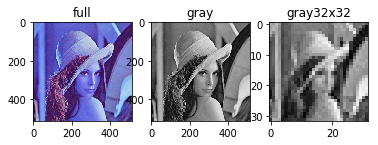

In [2]:
originImage = cv2.imread("../lena.jpg")
grayImage = cv2.cvtColor(originImage,cv2.COLOR_BGR2GRAY)
originImage32x32 = cv2.imread("../lena_32x32.jpg")
grayImage32x32 = cv2.cvtColor(originImage32x32,cv2.COLOR_BGR2GRAY)
plt.subplot(1, 3, 1)
plt.title("full")
plt.imshow(originImage)
plt.subplot(1, 3, 2)
plt.title("gray")
plt.gray()
plt.imshow(grayImage)
plt.subplot(1, 3, 3)
plt.title("gray32x32")
plt.gray()
plt.imshow(grayImage32x32)

#### Step1 计算图像x,y方向梯度

In [3]:
def get_img_gradient(src):
    #dx,dy=getSobelKernel(3)
    #print(dx)
    #print(dy)
    n=3
    r=int(n/2)
    smth_h=pascalSmooth(n)# 1xn
    diff_h=pascalDiff(n)  # 1xn
    img_x=conv1d_same(src,smth_h.transpose(),r,0,stride=1)
    img_x=conv1d_same(img_x,diff_h,0,r,stride=1)
    
    img_y=conv1d_same(src,smth_h,0,r,stride=1)
    img_y=conv1d_same(img_y,diff_h.transpose(),r,0,stride=1)
    return img_x,img_y
    
    

In [4]:
dx,dy=get_img_gradient(grayImage)

#### Step2 求解自相关矩阵

In [5]:
def calc_Autocorrelation_matrix(img_dx,img_dy):
    img_dx_squre=np.multiply(img_dx,img_dx)
    img_dxdy=np.multiply(img_dx,img_dy)
    img_dy_squre=np.multiply(img_dy,img_dy)
    
    img_dx_squre=Gaussian_filter(src=img_dx_squre,sigma=1.3, k_h=3,k_w=3)
    img_dxdy=Gaussian_filter(src=img_dxdy,sigma=1.3,k_h=3,k_w=3)
    img_dy_squre=Gaussian_filter(src=img_dy_squre,sigma=1.3, k_h=3,k_w=3)
    return img_dx_squre,img_dxdy,img_dy_squre
    

In [6]:
dx2,dxdy,dy2=calc_Autocorrelation_matrix(dx,dy)

#### Step3 求解自相关R

In [7]:
def calc_Ac_R(dx2,dxdy,dy2,k=0.05):
    det_C=np.zeros((dx.shape),np.float32)
    trace_C=np.zeros((dx.shape),np.float32)
    R=np.zeros((dx.shape),np.float32)
    det_C=np.multiply(dx2,dy2)-np.power(dxdy,2.0)
    trace_C=dx2+dy2
    R=det_C-k*np.power(trace_C,2.0)
    return R

    

In [8]:
R=calc_Ac_R(dx2,dxdy,dy2,k=0.05)

#### cv画圆型的api

圆的圆心为(255,255)，半径为127，线的颜色为红色，线的粗细为8，如下：
> cv2.circle(img, (255, 255), 127, (0, 0, 255), 8)

R mean:%s -40522748.0
R[i:3,j:506]=2701563.8


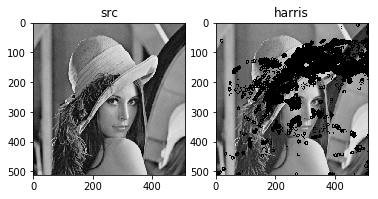

In [21]:
def draw_circle_and_show(src,R,thr,descp):
    w,h=src.shape
    plt.subplot(1, 2, 1)
    plt.title("src")
    plt.imshow(src)
    
    dest=src.copy()
    for i in range(w):
        for j in range(h):
            if R[i][j]>thr:
                if i <4:
                    print("R[i:%s,j:%s]=%s"%(i,j,R[i,j]))
                cv2.circle(dest,(i,j),5,(0,0,255),1)
                
    plt.subplot(1, 2, 2)
    plt.title(descp)
    plt.imshow(dest)

R_mean=np.mean(R)
print("R mean:%s",R_mean)
draw_circle_and_show(grayImage,R,2701563,"harris")